In [1]:
from torch_geometric.datasets import Entities
import os.path as osp
import networkx as nx
import igraph as ig
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch_geometric as pyg

import numpy as np

import LPGNN

device = 'cpu'

In [237]:
import importlib
importlib.reload(module=LPGNN.GraphNeuralNet)

<module 'LPGNN.GraphNeuralNet' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/GraphNeuralNet.py'>

In [13]:
# PS Network

G_nx, G = LPGNN.network_generator.generatePSNetwork_nx(N=100, avg_k=6, gamma=2.5, Temp=0.2, seed=100)
G_nx.graph['size'] = 60
data = pyg.utils.from_networkx(G_nx)

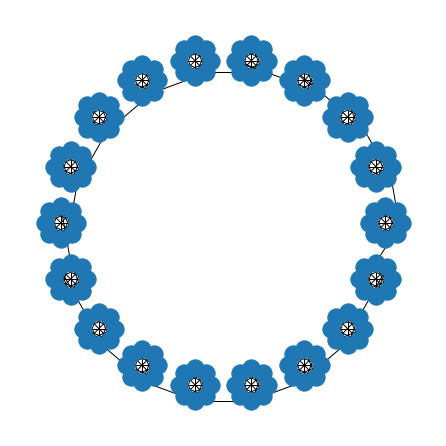

In [326]:
# Generate Barabasi-Albert graph

# G_nx = nx.barabasi_albert_graph(200, m=4)

# Generate Ring of Cliques

num_cliques = 18
clique_size = 8
r = 0.1
G_nx = nx.ring_of_cliques(num_cliques, clique_size)
G_nx.graph['pos'] = {}
for node in G_nx.nodes:
    c = node // clique_size
    theta_c = 2*np.pi/num_cliques*c
    x_c = np.cos(theta_c)
    y_c = np.sin(theta_c)
    i = node % clique_size
    theta_i = 2*np.pi/clique_size*i + np.pi/4*c
    x_i = r*np.cos(theta_i)
    y_i = r*np.sin(theta_i)
    G_nx.graph['pos'][node] = np.array([x_c+x_i, y_c+y_i])
G = ig.Graph(len(G_nx), list(zip(*list(zip(*nx.to_edgelist(G_nx)))[:2])))
fig = plt.figure(figsize=(6, 6))
nx.draw(G_nx, pos=G_nx.graph['pos'], with_labels=False)

In [14]:
# Set data.x to be the node positions returned by LaBNE, as a starting point for embedding
# Also include centrality measures

labne = LPGNN.network_generator.generateLaBNE(graph=G)
#data.x = torch.Tensor( np.transpose([labne.vs['x'], labne.vs['y']]) )
data.x = torch.Tensor( np.transpose([labne.vs['r'], labne.vs['theta'],]) )
                                     #list(nx.degree_centrality(G_nx).values()),
                                     #list(nx.closeness_centrality(G_nx).values())]) )

# Split data
train_data, val_data, test_data = LPGNN.DataSetup.train_test_split(data, test_ratio=0.05, val_ratio=0.05, neg_samples=True)

In [15]:
all_z = []

for i in range(1):
    # GraphSAGE model + training
    model = pyg.nn.GraphSAGE(in_channels=data.num_features, hidden_channels=20, out_channels=2, num_layers=4, dropout=0.1, root_weight=False, aggr="mean")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    _ = LPGNN.GraphNeuralNet.train_model(model, optimizer, train_data, test_data, val_data, epochs=1000)

    # Evaluate model
    model.eval()
    torch.no_grad()
    z = model.forward(data.x, data.edge_index)
    all_z.append(z.detach().numpy())
    # Save z as embedding
    #embedding = {node:np.array([value[0], value[1]]) for node, value in enumerate(z.detach().numpy())}


In [21]:
z = all_z[0]
G_nx.graph['r'] = {node:0 for node in G_nx.nodes}
G_nx.graph['theta'] = {node:0 for node in G_nx.nodes}
gamma = ig.power_law_fit(data=G.degree()).alpha
beta = 1/(gamma-1)

In [22]:
for t in range(G_nx.number_of_nodes()):
    r_t = np.log(t+1)
    G_nx.graph['r'][t] = 2*beta*r_t + 2*(1-beta)*np.log(G_nx.number_of_nodes())
    #labne_graph.vs[t]['r'] = 2*beta*r_t + 2*(1-beta)*np.log(N)
    G_nx.graph['theta'][t] = np.arctan2(z[t][1], z[t][0])
    if G_nx.graph['theta'][t] < 0:
        G_nx.graph['theta'][t] += 2*np.pi

min_theta = min(G_nx.graph['theta'].values())
max_theta = max(G_nx.graph['theta'].values())
for node in G_nx.nodes:
    G_nx.graph['theta'][node] = (G_nx.graph['theta'][node]-min_theta)/(max_theta-min_theta)*2*np.pi

In [23]:
#embedding = {node:value for node, value in enumerate(np.mean(all_z, axis=0))}
embedding = {node:np.array([G_nx.graph['r'][node]*np.cos(G_nx.graph['theta'][node]),
                            G_nx.graph['r'][node]*np.sin(G_nx.graph['theta'][node])]) for node, value in enumerate(z)}

(<Figure size 864x720 with 1 Axes>, <AxesSubplot:>)

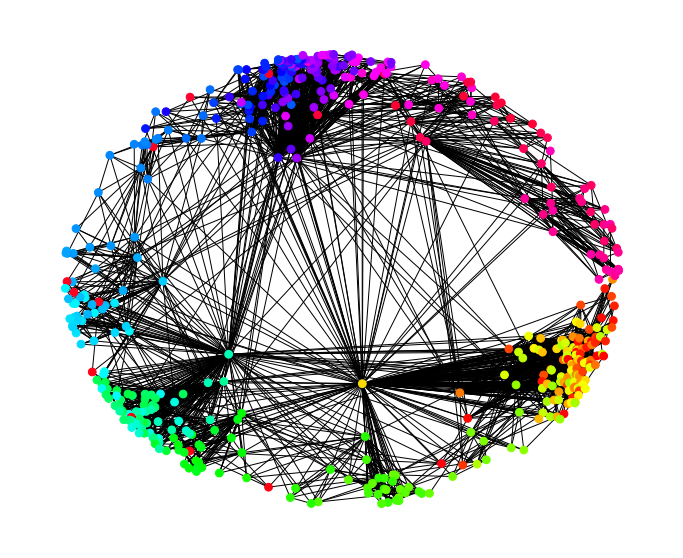

In [24]:
LPGNN.visualization.gnn_attr_passing.draw_embedding(G_nx, embedding=embedding)

In [24]:
#G_nx.graph['pos'] = nx.spring_layout(G_nx)

#def to_xy(G_nx):
#    return np.array([[G_nx.graph['r'][node]*np.cos(G_nx.graph['theta'][node]), G_nx.graph['r'][node]*np.sin(G_nx.graph['theta'][node])] for node in G_nx.nodes])

#xyG = np.array(list(G_nx.graph['pos']))
#xy_gnn_h = to_xy(G_nx)
xy_gnn_e = np.array(z.detach().numpy())
#labne = LPGNN.network_generator.generateLaBNE(graph=G)

NameError: name 'beta' is not defined

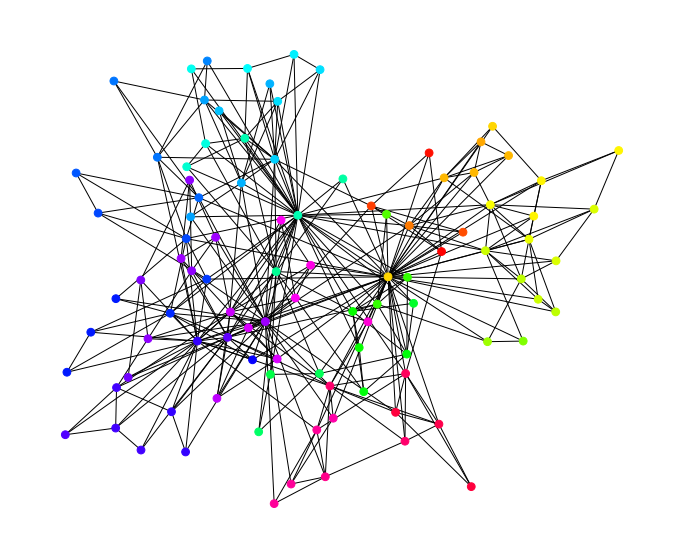

In [19]:
G_nx.graph['pos'] = nx.spring_layout(G_nx)
LPGNN.visualization.gnn_attr_passing.draw_embedding(G_nx, embedding=G_nx.graph['pos'])

for t in range(G_nx.number_of_nodes()):
    r_t = np.log(t+1)
    G_nx.graph['r'][t] = 2*beta*r_t + 2*(1-beta)*np.log(G_nx.number_of_nodes())
    #labne_graph.vs[t]['r'] = 2*beta*r_t + 2*(1-beta)*np.log(N)
    G_nx.graph['theta'][t] = np.arctan2(G_nx.graph['pos'][t][1], G_nx.graph['pos'][t][0])
    if G_nx.graph['theta'][t] < 0:
        G_nx.graph['theta'][t] += 2*np.pi

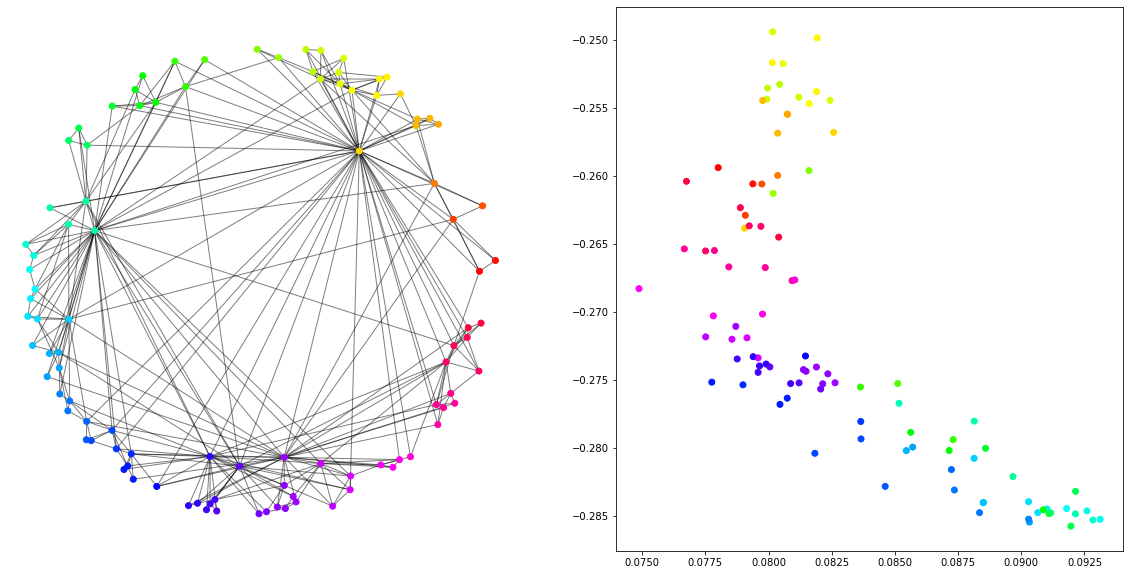

In [26]:
fig = plt.figure(figsize=(20, 10))
ax_labne = fig.add_subplot(121, projection='polar')
ax_gnn_e = fig.add_subplot(122)
#ax_gnn_h = fig.add_subplot(133, projection='polar')

ax_labne.set_axis_off()
nx.draw_networkx_edges(G_nx, np.transpose([G.vs['theta'], G.vs['r']]), alpha=0.5, ax=ax_labne)
#axs[0].scatter(xyG[:,0], xyG[:,1], c=G_nx.graph['color'])
ax_labne.scatter(G.vs['theta'], G.vs['r'], c=G_nx.graph['color'])
ax_gnn_e.scatter(xy_gnn_e[:,0], xy_gnn_e[:,1], c=G_nx.graph['color'])
#ax_gnn_h.scatter(list(G_nx.graph['theta'].values()), list(G_nx.graph['r'].values()), c=G_nx.graph['color'])

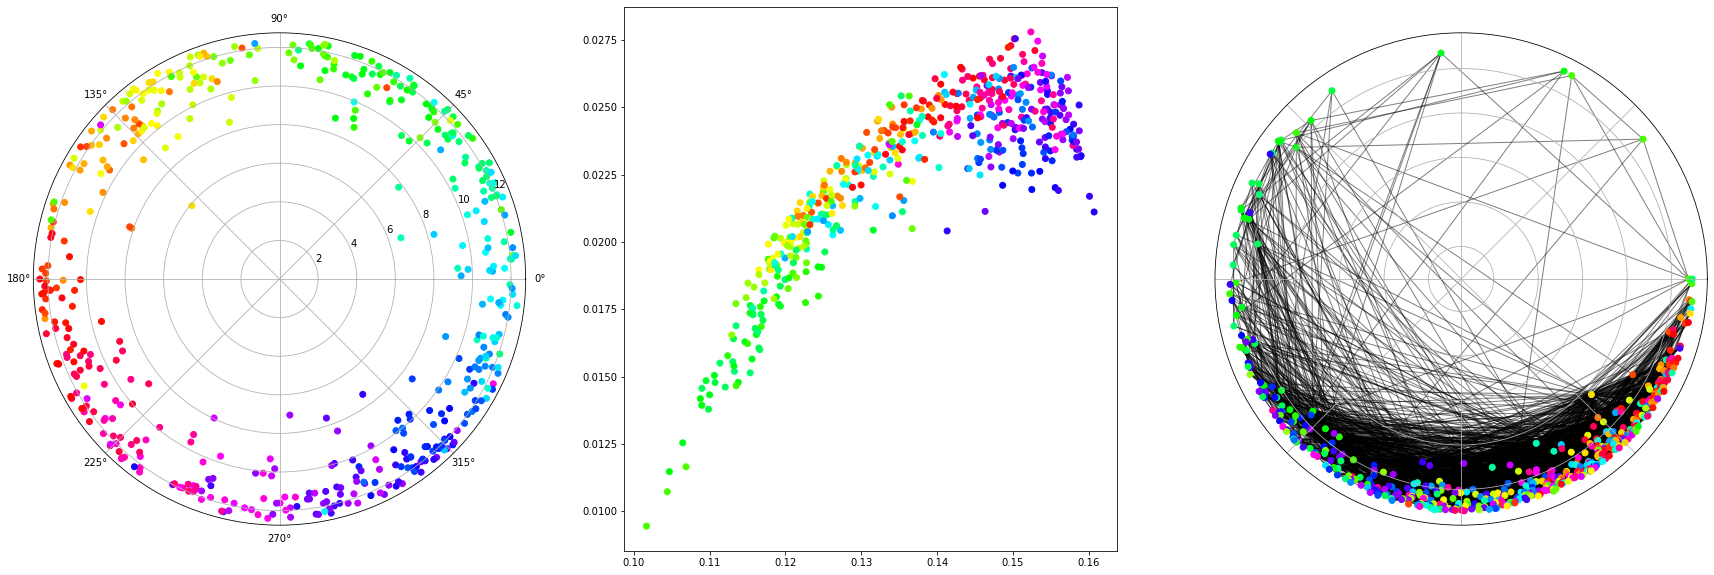

In [70]:
fig = plt.figure(figsize=(30, 10))
ax_labne = fig.add_subplot(131, projection='polar')
ax_gnn_e = fig.add_subplot(132)
ax_gnn_h = fig.add_subplot(133, projection='polar')

nx.draw_networkx_edges(G_nx, np.transpose([list(G_nx.graph['theta'].values()), list(G_nx.graph['r'].values())]), alpha=0.5, ax=ax_gnn_h)
#axs[0].scatter(xyG[:,0], xyG[:,1], c=G_nx.graph['color'])
ax_labne.scatter(labne.vs['theta'], labne.vs['r'], c=G_nx.graph['color'])
ax_gnn_e.scatter(xy_gnn_e[:,0], xy_gnn_e[:,1], c=G_nx.graph['color'])
ax_gnn_h.scatter(list(G_nx.graph['theta'].values()), list(G_nx.graph['r'].values()), c=G_nx.graph['color'])

In [32]:
def pointsToDistances(G_nx, space='euclidean'):
    p = []
    for i in range(G_nx.number_of_nodes()):
        for j in range(i+1, G_nx.number_of_nodes()):
            if space == 'euclidean':
                p.append([i, j, np.linalg.norm(G_nx.graph['pos'][i]-G_nx.graph['pos'][j])])
            elif space == 'hyperbolic':
                p.append([i, j, LPGNN.metrics.hyperbolic_distance(r_1=G_nx.graph['r'][i], theta_1=G_nx.graph['theta'][i], r_2=G_nx.graph['r'][j], theta_2=G_nx.graph['theta'][j])])
    return p

def distance_matrix_to_scores(d):
    scores = []
    for i in range(d.shape[0]):
        for j in range(i+1, d.shape[0]):
            scores.append([i, j, d[i, j]])
    return scores

In [33]:
# scores = pointsToDistances(z.detach().numpy())
# Sort scores by distance
# scores = distance_matrix_to_scores(d)
# scores = sorted(scores, key=lambda x: x[2])
d = pointsToDistances(G_nx, space='hyperbolic')
scores = sorted(d, key=lambda x: x[2])

In [34]:
R, P, preds = LPGNN.LinkPrediction.precision_recall(test_data=test_data, predictions=scores)

In [35]:
PR_labne = LPGNN.GraphNeuralNet.LaBNE(PS=G, test=test_data)

/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/network_analysis.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  link_scores = np.array(link_scores)


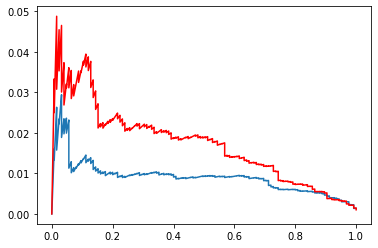

In [36]:
plt.plot(R, P)
plt.plot(PR_labne['recall'], PR_labne['precision'], c='red')
#plt.ylim(0, 0.1)

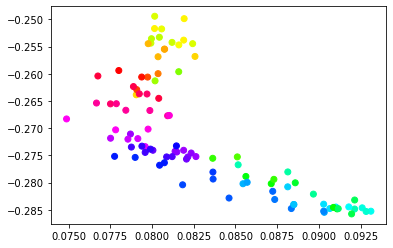

In [31]:
plt.scatter(z.detach().numpy()[:,0], z.detach().numpy()[:,1], c=G_nx.graph['color'])

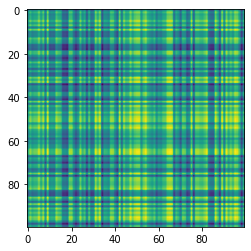

In [30]:
plt.imshow(P.detach().numpy())

In [35]:
z[0] @ z[1].T

tensor(0.0798, grad_fn=<DotBackward0>)